# ETH Stock Forcasting with Pytorch and LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
import time
import torch.nn as nn
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# data = pd.read_csv('AMZN.csv')

In [28]:

def fetch_binance_ohlcv(symbol='ETHUSDT', interval='1m', limit=1000, total=10080):
    url = 'https://api.binance.com/api/v3/klines'
    all_data = []
    end_time = None
    while len(all_data) < total:
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': min(limit, total - len(all_data))
        }
        if end_time:
            params['endTime'] = end_time
        resp = requests.get(url, params=params)
        data = resp.json()
        if not data:
            break
        all_data = data + all_data  # prepend
        end_time = data[0][0] - 60 * 1000
        time.sleep(0.5)
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)
    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]


# 获取最近600天ETH日线数据
data = fetch_binance_ohlcv(total=20*24*60)
data.to_csv('eth_daily.csv', index=False)

# data = pd.read_csv('eth_daily.csv', parse_dates=['timestamp'])
print(data.head())
print(f"共获取{len(data)}M数据")

KeyboardInterrupt: 

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

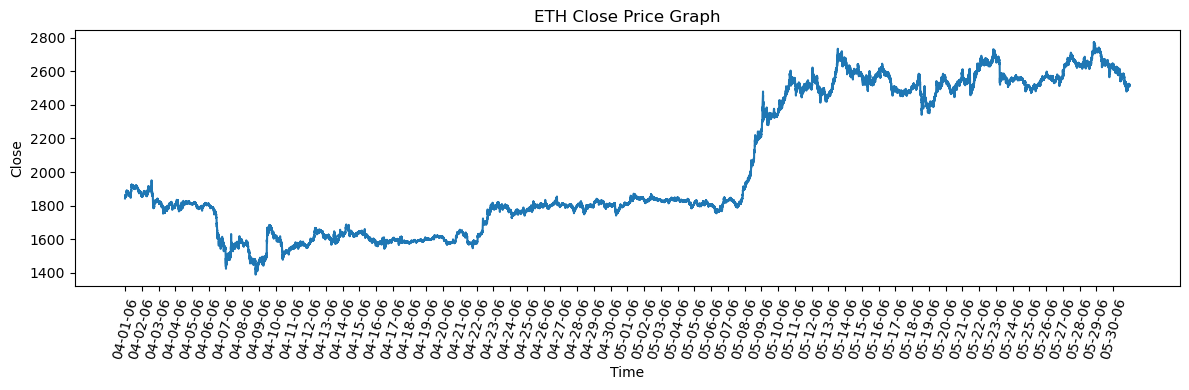

In [5]:
# 确保timestamp为datetime类型
data['timestamp'] = pd.to_datetime(data['timestamp'])

plt.figure(figsize=(12, 4))
plt.plot(data['timestamp'], data['close'])

# 只显示部分x轴标签，避免过密
step = len(data) // 60  # 每小时显示一个
xticks = data['timestamp'][::step]
xticklabels = [f"{ts.strftime('%m-%d-%H')}" for ts in xticks]
plt.xticks(xticks, xticklabels, rotation=75)
plt.xlabel('Time')
plt.ylabel('Close')
plt.title('ETH Close Price Graph')
plt.tight_layout()
plt.show()

In [6]:
from copy import deepcopy as dc

lookback = 60
# To avoid DataFrame fragmentation, build all shifted columns first, then concat
shifted_cols = []
for i in range(1, lookback + 1):
    for col in ['open', 'high', 'low', 'close', 'volume']:
        shifted = data[col].shift(i)
        shifted.name = f'{col}(t-{i})'
        shifted_cols.append(shifted)
shifted_df = pd.concat([data] + shifted_cols, axis=1)
shifted_df.set_index('timestamp', inplace=True)
shifted_df.dropna(inplace=True)

shifted_df


,open,high,low,close,volume,open(t-1),high(t-1),low(t-1),close(t-1),volume(t-1),...,open(t-59),high(t-59),low(t-59),close(t-59),volume(t-59),open(t-60),high(t-60),low(t-60),close(t-60),volume(t-60)
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-04-01 07:13:00,1859.28,1860.71,1859.27,1860.45,90.9708,1859.60,1860.23,1858.83,1859.27,173.5282,...,1842.74,1844.38,1842.73,1844.37,129.3229,1841.66,1842.95,1841.66,1842.74,93.6832
2025-04-01 07:14:00,1860.45,1860.45,1858.89,1858.89,135.5466,1859.28,1860.71,1859.27,1860.45,90.9708,...,1844.37,1846.60,1844.11,1845.43,279.3887,1842.74,1844.38,1842.73,1844.37,129.3229
2025-04-01 07:15:00,1858.90,1858.90,1857.00,1857.57,157.3562,1860.45,1860.45,1858.89,1858.89,135.5466,...,1845.44,1846.87,1845.43,1846.86,282.4198,1844.37,1846.60,1844.11,1845.43,279.3887
2025-04-01 07:16:00,1857.57,1857.58,1856.73,1856.96,167.4643,1858.90,1858.90,1857.00,1857.57,157.3562,...,1846.87,1848.44,1846.87,1847.34,126.7872,1845.44,1846.87,1845.43,1846.86,282.4198
2025-04-01 07:17:00,1856.97,1856.97,1855.92,1856.56,159.7763,1857.57,1857.58,1856.73,1856.96,167.4643,...,1847.34,1847.35,1846.46,1846.46,73.8348,1846.87,1848.44,1846.87,1847.34,126.7872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31 06:08:00,2518.40,2520.00,2518.30,2519.93,556.7182,2517.24,2518.40,2516.65,2518.39,62.1370,...,2521.35,2522.00,2520.90,2520.91,61.8343,2523.19,2523.82,2521.35,2521.36,303.0871
2025-05-31 06:09:00,2519.93,2520.20,2518.00,2518.71,143.9602,2518.40,2520.00,2518.30,2519.93,556.7182,...,2520.90,2521.19,2519.60,2520.29,92.3982,2521.35,2522.00,2520.90,2520.91,61.8343
2025-05-31 06:10:00,2518.70,2518.70,2514.61,2514.61,347.8781,2519.93,2520.20,2518.00,2518.71,143.9602,...,2520.30,2520.36,2517.86,2518.00,155.2244,2520.90,2521.19,2519.60,2520.29,92.3982


In [7]:
feature_cols = []
for i in range(lookback, 0, -1):
    for col in ['open', 'high', 'low', 'close', 'volume']:
        feature_cols.append(f'{col}(t-{i})')
X = shifted_df[feature_cols].to_numpy()
y = shifted_df['close'].to_numpy()
print(X.shape, y.shape)


(86340, 300) (86340,)


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# reshape for LSTM: (samples, lookback, features)
X = X.reshape((-1, lookback, 5))
X.shape

(86340, 60, 5)

In [9]:
X = dc(np.flip(X,axis=1))
X

array([[[-0.32060898, -0.33512257, -0.31704434, -0.32112357,
         -0.98906672],
        [-0.32179286, -0.33602918, -0.3173903 , -0.32066155,
         -0.98859997],
        [-0.32143192, -0.33618748, -0.31858675, -0.32184547,
         -0.98460783],
        ...,
        [-0.34259747, -0.35473705, -0.33826328, -0.34110581,
         -0.98232118],
        [-0.3449508 , -0.35793177, -0.34025255, -0.34263624,
         -0.99188352],
        [-0.34651007, -0.35998964, -0.34179496, -0.34498964,
         -0.99415452]],

       [[-0.32107098, -0.33443182, -0.31641008, -0.31941988,
         -0.99432735],
        [-0.32060898, -0.33512257, -0.31704434, -0.32112357,
         -0.98906672],
        [-0.32179286, -0.33602918, -0.3173903 , -0.32066155,
         -0.98859997],
        ...,
        [-0.34105265, -0.3543485 , -0.33636049, -0.33904117,
         -0.98212804],
        [-0.34259747, -0.35473705, -0.33826328, -0.34110581,
         -0.98232118],
        [-0.3449508 , -0.35793177, -0.34025255, 

In [10]:
split_index = int(len(X)*0.95)
split_index

82023

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [12]:
X_train = X_train.reshape((-1,lookback,5))
X_test = X_test.reshape((-1,lookback,5))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [13]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [14]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i],self.y[i]

train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [15]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [24]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stzcked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,1)
    
    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stzcked_layers,batch_size,self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stzcked_layers,batch_size,self.hidden_size).to(device)
        out,_ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out
model = LSTM(5,16,8)
# if os.path.exists('best_model.pth'):
#     model.load_state_dict(torch.load('eth_lstm_model.pth', map_location=device))
#     print("已加载保存的模型参数")
model.to(device)


LSTM(
  (lstm): LSTM(5, 16, num_layers=8, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [25]:
train_loss_array = []

def train_one_epoch():
    model.train(True)
    print(f'Epoch:{epoch+1}')
    running_loss = 0.0

    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output,y_batch)
        
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss/100
            print('Batch {0}, Loss:{1:3f}'.format(batch_index,avg_loss_across_batches))
            train_loss_array.append(loss.item())
            running_loss = 0.0
        
    print()



In [26]:
val_loss_array = []
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output,y_batch)
            running_loss += loss.item()
        val_loss_array.append(running_loss)
        avg_loss_across_batches = running_loss/len(test_loader)
    print('Val Loss: {0:3f}'.format(avg_loss_across_batches))
    print('************************************************')
    print()

In [27]:
learning_rate = 0.001
num_epoch = 2
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epoch):
    train_one_epoch()
    validate_one_epoch()

# 保存loss_array为csv文件
np.savetxt('train_loss_array.csv', np.array(train_loss_array), delimiter=',', header='train_loss', comments='')
np.savetxt('val_loss_array.csv', np.array(val_loss_array), delimiter=',', header='val_loss', comments='')

Epoch:1
Batch 99, Loss:0.227963
Batch 199, Loss:0.027524
Batch 299, Loss:0.027055
Batch 399, Loss:0.030553
Batch 499, Loss:0.181343
Batch 599, Loss:0.188484
Batch 699, Loss:0.029739
Batch 799, Loss:0.027114
Batch 899, Loss:0.027091
Batch 999, Loss:0.028658
Batch 1099, Loss:0.027701
Batch 1199, Loss:0.025767
Batch 1299, Loss:0.027090
Batch 1399, Loss:0.027331
Batch 1499, Loss:0.027405
Batch 1599, Loss:0.028378
Batch 1699, Loss:0.026944
Batch 1799, Loss:0.027104
Batch 1899, Loss:0.026843
Batch 1999, Loss:0.025716
Batch 2099, Loss:0.026847
Batch 2199, Loss:0.027198
Batch 2299, Loss:0.027433
Batch 2399, Loss:0.027568
Batch 2499, Loss:0.026985
Batch 2599, Loss:0.028818
Batch 2699, Loss:0.027914
Batch 2799, Loss:0.027840
Batch 2899, Loss:0.027161
Batch 2999, Loss:0.026801
Batch 3099, Loss:0.026044
Batch 3199, Loss:0.026883
Batch 3299, Loss:0.026688
Batch 3399, Loss:0.028059
Batch 3499, Loss:0.026770
Batch 3599, Loss:0.029177
Batch 3699, Loss:0.029426
Batch 3799, Loss:0.026172


KeyboardInterrupt: 

In [23]:
torch.save(model.state_dict(), 'eth_lstm_model.pth')
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train,label='Actual Close')
plt.plot(predicted,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 25.99 GiB. GPU 0 has a total capacity of 8.00 GiB of which 4.89 GiB is free. Of the allocated memory 2.00 GiB is allocated by PyTorch, and 13.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [21]:
train_loss_df = pd.read_csv('train_loss_array.csv')
val_loss_df = pd.read_csv('val_loss_array.csv')
plt.plot(train_loss_df['train_loss'], label='Train Loss')
plt.plot(val_loss_df['val_loss'], label='Val Loss')
plt.legend()
# plt.plot(train_loss_df)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'train_loss_array.csv'

In [ ]:
train_predictions = predicted.flatten()
train_predictions.shape

dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = train_predictions
dummies = scaler_y.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([2549.86314877, 2545.97643058, 2544.92052097, ..., 2592.06204588,
       2595.20759017, 2599.11949431])

In [ ]:
dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = y_train.flatten()
dummies = scaler_y.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([2543.40000075, 2542.64999982, 2543.52999775, ..., 2593.51000024,
       2597.38000028, 2598.98000028])

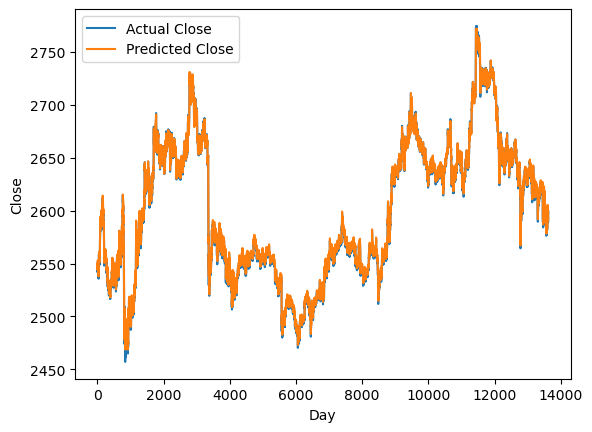

In [ ]:
plt.plot(new_y_train,label='Actual Close')
plt.plot(train_predictions,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
test_prediction = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:,0] = test_prediction
dummies = scaler_y.inverse_transform(dummies)

test_prediction = dc(dummies[:,0])
test_prediction

array([2601.18540594, 2599.30066674, 2598.49807122, 2597.35503885,
       2599.55298586, 2601.9567855 , 2600.17974652, 2603.1931349 ,
       2605.79772669, 2607.38603179, 2608.25150768, 2608.22270703,
       2608.18470419, 2607.85911197, 2607.97980812, 2604.40829474,
       2605.49729088, 2608.00859518, 2608.95419722, 2611.01637658,
       2608.57380011, 2605.00500573, 2604.96617868, 2601.14400878,
       2600.92732385, 2603.01683564, 2609.33139203, 2610.96187596,
       2611.8091708 , 2608.84415612, 2612.3305018 , 2614.66471631,
       2616.55331009, 2615.71454981, 2614.28240136, 2614.20444475,
       2612.17486508, 2610.73802603, 2608.86413035, 2608.13933605,
       2607.99232429, 2605.13965849, 2602.40057524, 2602.02557241,
       2601.46144693, 2603.76171288, 2606.49632236, 2606.4973705 ,
       2605.86959656, 2606.90782437, 2606.15541285, 2606.24957005,
       2606.67049699, 2604.54916186, 2606.17112069, 2606.16843241,
       2607.82586414, 2602.70653591, 2603.92764187, 2605.89076

In [ ]:
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:,0] = y_test.flatten()
dummies = scaler_y.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])
new_y_test.shape

(717,)

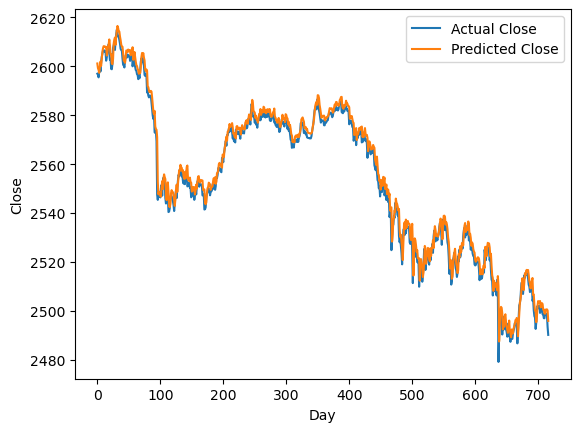

In [ ]:
plt.plot(new_y_test,label='Actual Close')
plt.plot(test_prediction,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

未来30天预测收盘价： [2495.8500650644305, 2500.1363315701487, 2500.578698587418, 2500.29404091835, 2500.5103134393694, 2498.8218695759774, 2498.9492338418963, 2500.5266676425936, 2500.4909341812136, 2502.7888226270675, 2503.129878664017, 2501.939859867096, 2501.393270254135, 2504.030191731453, 2503.1519993782044, 2503.373282146454, 2504.0120035886766, 2502.047287130356, 2497.5960322380065, 2495.381682574749, 2499.5768760204314, 2500.214094388485, 2502.5033236145973, 2506.7255534887313, 2506.610383975506, 2513.4564897775654, 2512.3890140652657, 2510.686163377762, 2509.29015724659, 2511.3684834241867, 2512.3573644280436, 2514.870173573494, 2516.842414855957, 2516.120523309708, 2516.8934437513353, 2516.64071931839, 2514.740663409233, 2515.5097930788997, 2511.6784948349, 2508.677186584473, 2509.6267324209216, 2513.51310557127, 2511.1861104249956, 2507.161879849434, 2504.8918030023574, 2503.7061516284944, 2498.597429406643, 2494.269341516495, 2489.8268781900406, 2496.6304725170135, 2497.393996381759

d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


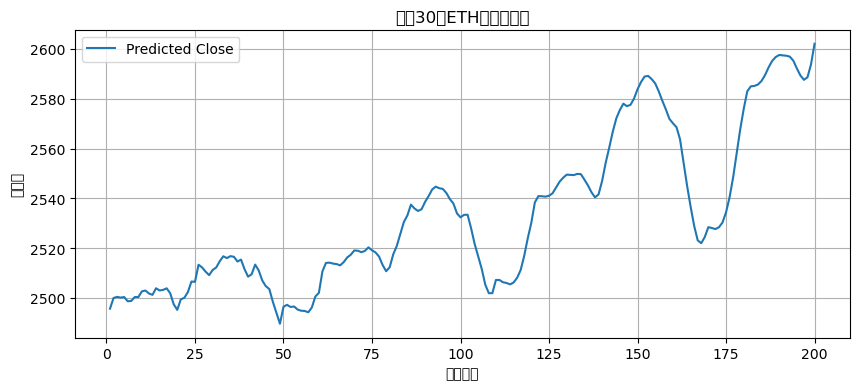

In [ ]:
future_steps = 200
last_seq = X_test[-1].cpu().numpy()  # shape: (lookback, 5)
future_preds = []

for _ in range(future_steps):
    inp = torch.tensor(last_seq.reshape(1, lookback, 5), dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(inp).cpu().numpy()[0, 0]
    # 只反归一化1个值
    pred_real = scaler_y.inverse_transform([[pred]])[0, 0]
    future_preds.append(pred_real)
    # 更新last_seq，只更新close，其他特征保持不变
    new_row = last_seq[-1].copy()
    new_row[3] = pred  # 只更新close列（第4列，索引3）
    last_seq = np.vstack([last_seq[1:], new_row])


print("未来30天预测收盘价：", future_preds)

# 可视化未来30天预测收盘价
plt.figure(figsize=(10, 4))
plt.plot(range(1, future_steps + 1), future_preds, label='Predicted Close')
plt.xlabel('未来天数')
plt.ylabel('收盘价')
plt.title('未来30天ETH收盘价预测')
plt.legend()
plt.grid(True)
plt.show()